In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from Unet.rle import masks_as_image, montage_rgb, montage
from skimage.segmentation import mark_boundaries
import seaborn as sns
from sklearn.utils import resample
from tqdm import tqdm

In [20]:
BATCH_SIZE=32
IMG_SCALING = (3, 3)

In [6]:
train_image_dir = 'train_v2'
test_image_dir = 'test_v2'

print(f'Train folder contains {len(os.listdir(train_image_dir))} images\nTest folder contains {len(os.listdir(test_image_dir))} images')

Train folder contains 192556 images
Test folder contains 15606 images


In [32]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
df.head(5)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
nempty = df.EncodedPixels.notna()
print(f"Dataset size: {len(df)}\nUnique number of images: {df.ImageId.nunique()}\nThere are {nempty.sum()} masks in {df[nempty].ImageId.nunique()} images\nThere are {(~nempty).sum()} empty images in {df.ImageId.nunique()} unique images")

Dataset size: 231723
Unique number of images: 192556
There are 81723 masks in 42556 images
There are 150000 empty images in 192556 unique images


In [34]:
df['ships'] = df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0) # Let's see if each image has ship or not
unique_img_ids = df.groupby('ImageId').agg({'ships': 'sum'}).reset_index() # Calculating amount of ships per image
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0) # To keep metric that tells if image has ships

unique_img_ids

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0
...,...,...,...
192551,fffedbb6b.jpg,0,0.0
192552,ffff2aa57.jpg,0,0.0
192553,ffff6e525.jpg,0,0.0
192554,ffffc50b4.jpg,0,0.0


<Axes: xlabel='ships', ylabel='count'>

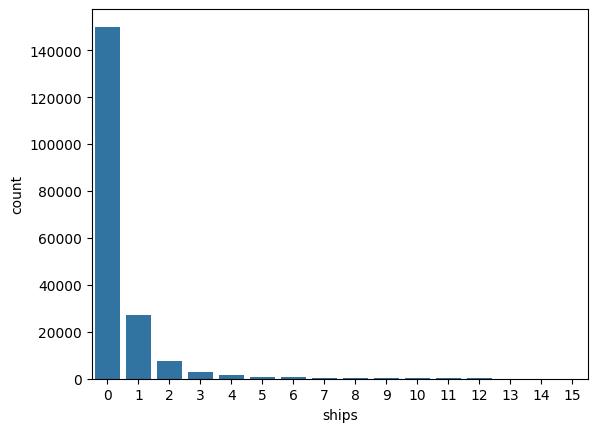

In [38]:
sns.countplot(unique_img_ids, x='ships') # Calculating number of images that have particular amount of ships

The dataset is highly unbalanced and it needs undersampling.

,ImageId,ships,has_ship,file_size_kb
73743,620efee61.jpg,0,0.0,107.130859
90233,77dc49d2d.jpg,0,0.0,310.681641
145365,c148e4e72.jpg,0,0.0,92.888672
14750,138966fce.jpg,0,0.0,190.936523
26704,238aca899.jpg,1,1.0,119.059570
82624,6daf83e5a.jpg,2,1.0,103.435547
110833,9353f70e5.jpg,0,0.0,99.063477


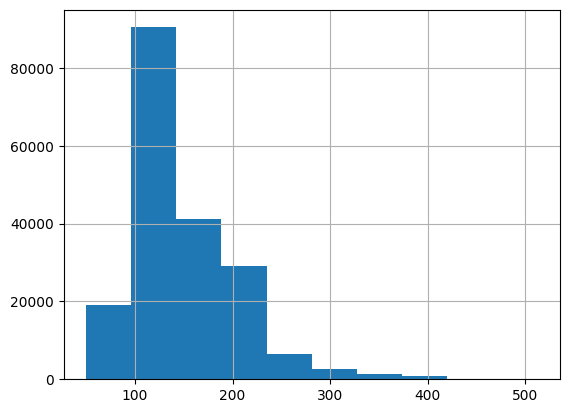

In [39]:
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
df.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [ ]:
# This is the first option of undersampling
# Separate the dataset into images with ships and images without ships
images_with_ships = unique_img_ids[unique_img_ids['has_ship'] == 1]
images_without_ships = unique_img_ids[unique_img_ids['has_ship'] == 0]

# Undersample the images without ships to achieve a balanced dataset
undersampled_images_without_ships = resample(images_without_ships,
                                            replace=False,  # Set to True if you want to allow duplicates
                                            n_samples=len(images_with_ships),
                                            random_state=42)  # Set a random seed for reproducibility
# Combine the undersampled images without ships with the images containing ships
undersampled_df = pd.concat([images_with_ships, undersampled_images_without_ships])

# Shuffle the dataframe to ensure randomness
balanced_train_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

12788 masks


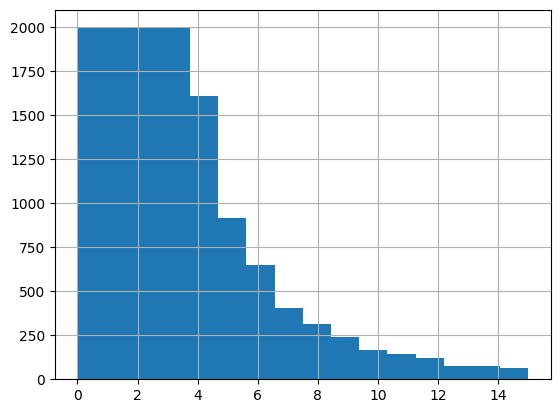

In [7]:
# This is the second option of undersampling (I used this)
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [8]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


In [9]:
train_df.to_csv('train_df.csv', index=False)
valid_df.to_csv('valid_df.csv', index=False)

In [22]:
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.segmentation import find_boundaries
from skimage.draw import polygon

def make_image_gen_test(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    
    def generator():
        while True:
            np.random.shuffle(all_batches)
            for c_img_id, c_masks in all_batches:
                rgb_path = os.path.join(train_image_dir, c_img_id)
                c_img = imread(rgb_path)
                c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
                
                if IMG_SCALING is not None:
                    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                    c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
                
                yield c_img/255.0, c_mask

    dataset = tf.data.Dataset.from_generator(generator,
                                             output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
                                                               tf.TensorSpec(shape=(None, None, 1), dtype=tf.uint8)))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [27]:
train_ds = make_image_gen_test(train_df, 3)

In [32]:
x, y = next(train_ds.as_numpy_iterator())

x.shape, y.shape

((3, 256, 256, 3), (3, 256, 256, 1))

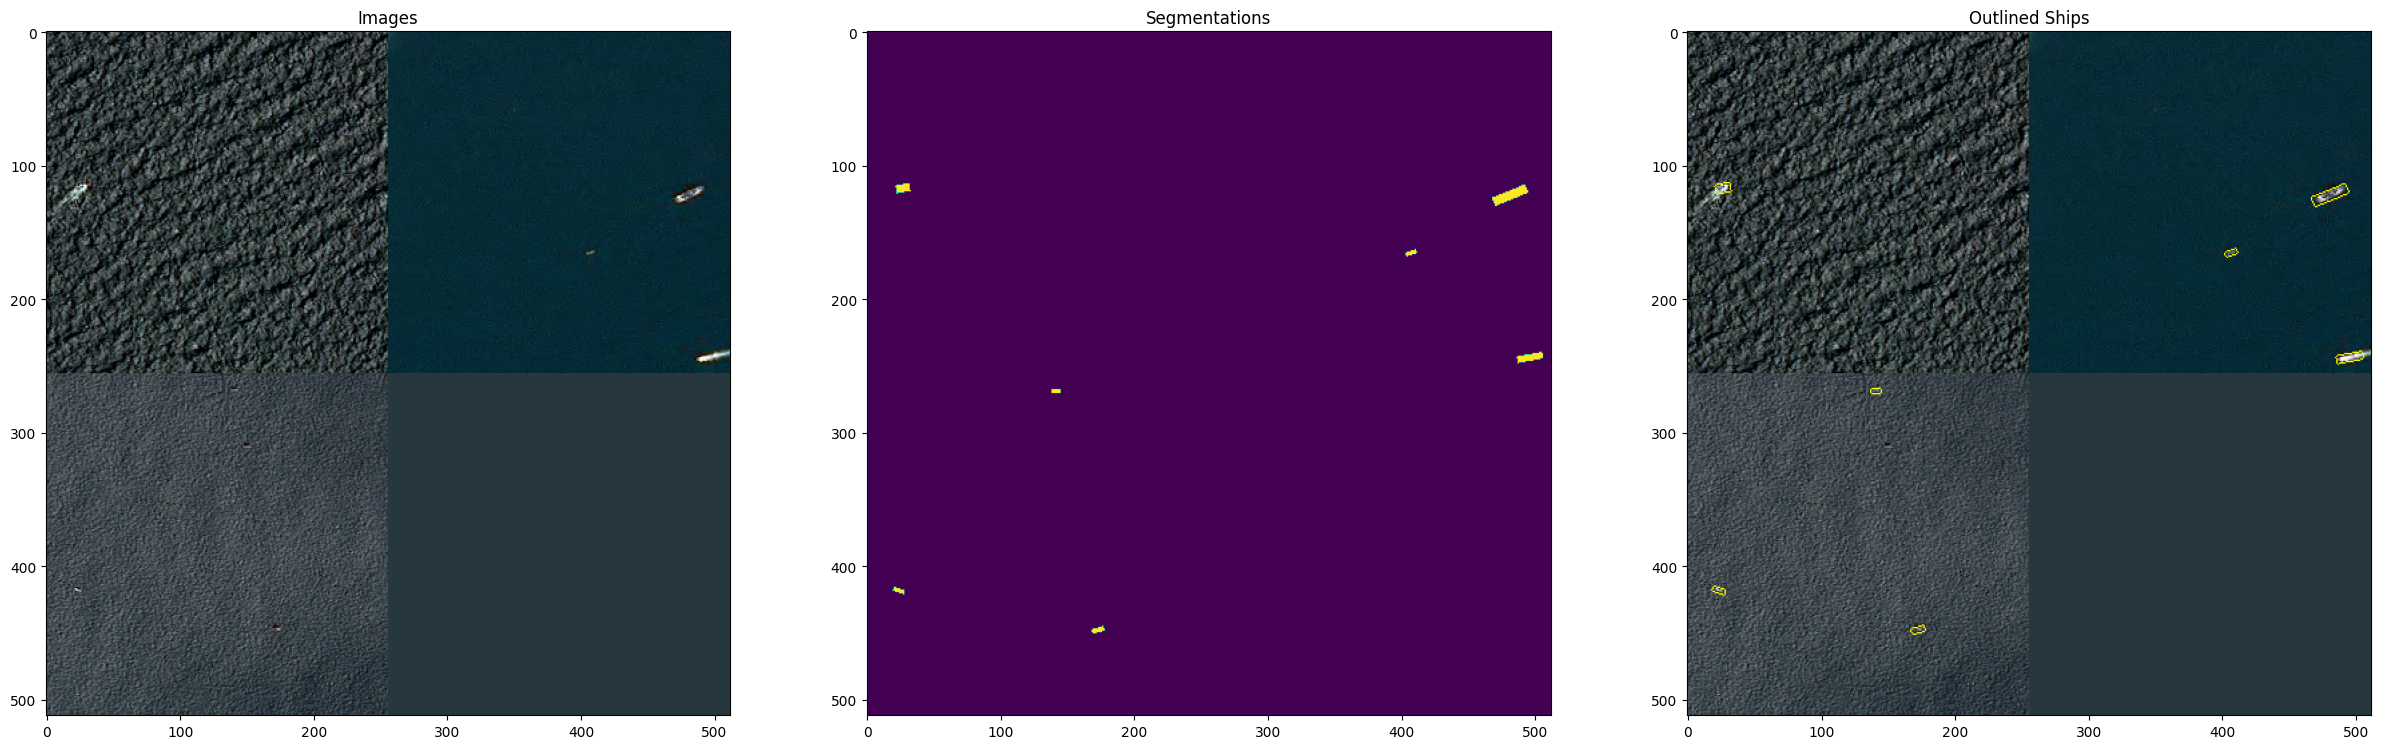

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(x)
batch_seg = montage(y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

### When I tried to improve a model performance I noticed that some files couldn't be opened, leading to Errors in learning. So this step is crucial to prevent corruption in the middle of learning

In [2]:
img_to_drop = []
for file in tqdm(os.listdir('train_v2')):
    try:
        img = plt.imread(os.path.join('train_v2', file))
    except Exception as e:
        print(f'Cannot read image {file}')
        img_to_drop.append(file)
        continue
        
# len(img_to_drop) 

 12%|█▏        | 22589/192556 [10:43<1:20:44, 35.08it/s]


KeyboardInterrupt: 

## I don't have time for this searching, and it consumes a lot of resources. I searched on Kaggle and someone told that there are a list of files that can't be opened: 
`exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']. (ref. https://www.kaggle.com/code/hmendonca/airbus-mask-rcnn-and-coco-transfer-learning) I will delete those files in further improving the project`